In [1]:
import numpy as np 
import pandas as pd 
import pickle

import torch 
import torch.nn as nn 
import torch.optim as optim
from sklearn.manifold import MDS

from tqdm import tqdm

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.env_fn import gauss_blob_task
from utils.model import MLP
from utils.analysis import rotate
viz.get_style()

In [2]:
x = np.vstack([np.tile(np.linspace(-2, 2, 5), 5),
           np.repeat(np.linspace(-2, 2, 5), 5)]).T

(-2.2, 2.2)

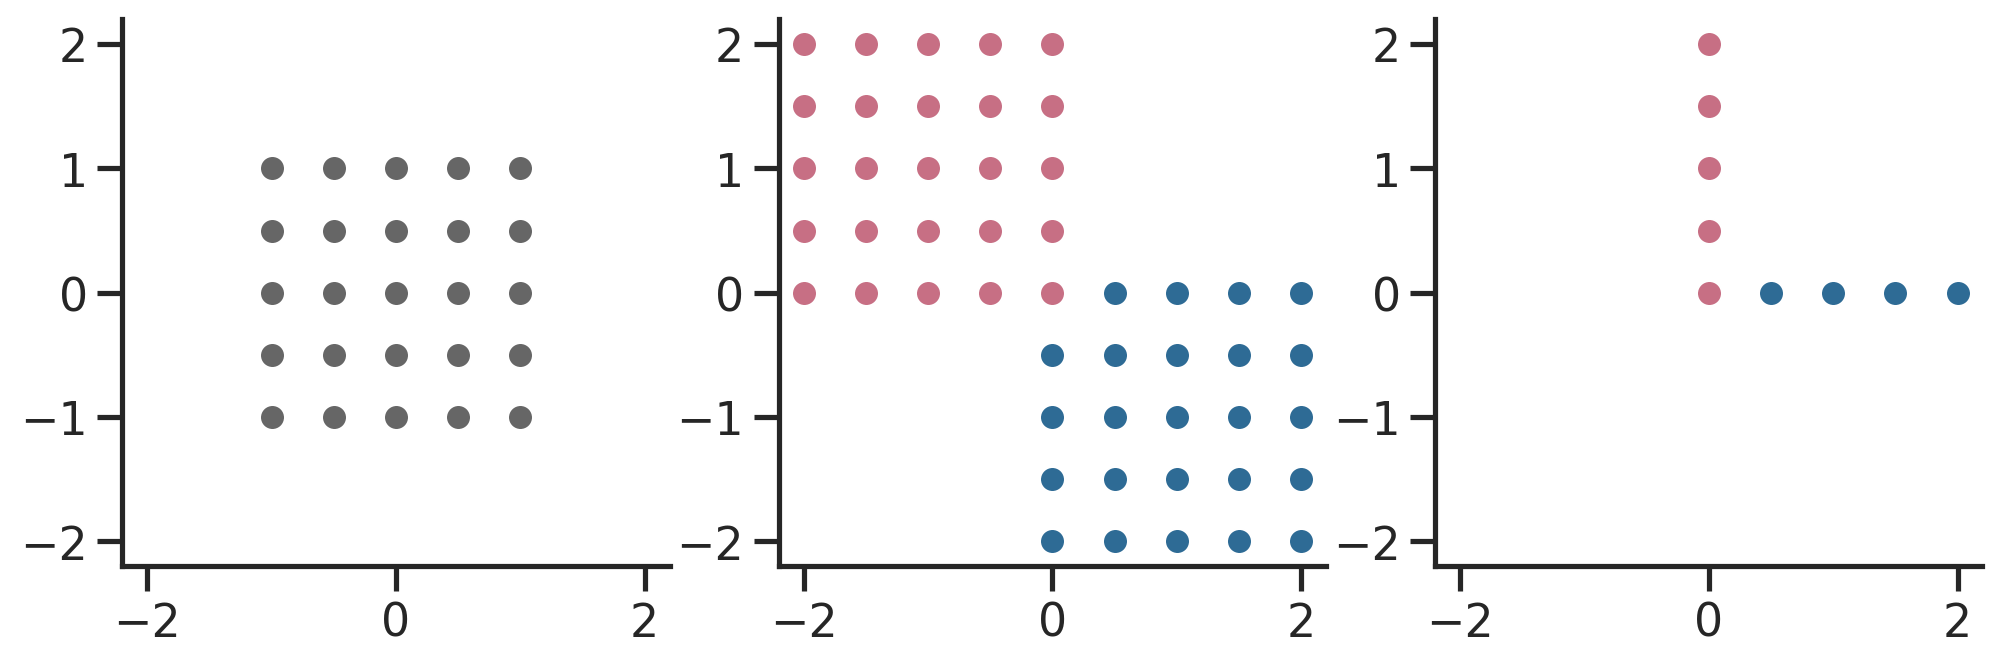

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax=axs[0]
h1=(x@np.array([.5, 0])) 
h2=(x@np.array([0, .5])) 
sns.scatterplot(x=h1, y=h2, color=[.4, .4, .4], ax=ax)
ax.set_box_aspect(1)
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-2.2, 2.2])
ax=axs[1]
h1=(x@np.array([.5, 0])) + 1
h2=(x@np.array([0, .5])) - 1
sns.scatterplot(x=h1, y=h2, color=viz.Blue, ax=ax)
h1=(x@np.array([.5, 0])) - 1
h2=(x@np.array([0, .5])) + 1
sns.scatterplot(x=h1, y=h2, color=viz.Red, ax=ax)
ax.set_box_aspect(1)
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-2.2, 2.2])
ax=axs[2]
h1=(x@np.array([.5, 0])) + 1
h2=(x@np.array([0, .5])) - 1
sns.scatterplot(x=h1*(h1>0), y=h2*(h2>0), color=viz.Blue, ax=ax)
h1=(x@np.array([.5, 0])) - 1
h2=(x@np.array([0, .5])) + 1
sns.scatterplot(x=h1*(h1>0), y=h2*(h2>0), color=viz.Red, ax=ax)
ax.set_box_aspect(1)
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-2.2, 2.2])

# Selectivity

In [4]:
with open('../data/weights_lr=.005.pkl', 'rb')as handle:
    weights = pickle.load(handle)

In [6]:
selectivity = {'corr': [], 'percent': [], 'neuron_type': [], 'sig': []}
for sig_w in [.01, .4, 3]:
    sig_c = 1.5
    env  = gauss_blob_task()
    x, y = gauss_blob_task().instan()
    for i in range(len(weights[sig_w]['param'])):
        n = len(weights[sig_w]['param'])
        model = MLP(25, 2, 100, 1, .001, sig_w, sig_c, .1)
        model.w_hxs = weights[sig_w]['param'][i]['w1'][:, :25]
        model.w_hxc = weights[sig_w]['param'][i]['w1'][:, 25:]
        model.b_hx  = weights[sig_w]['param'][i]['b1']
        model.w_yh  = weights[sig_w]['param'][i]['w2']
        model.b_yh  = weights[sig_w]['param'][i]['b2']
        model.fprop(x[:, :25].T, x[:, 25:].T, y.reshape([1, -1]))
        z = model.h_out.T
        z_task_A = z[:25, :].mean(0)
        z_task_B = z[25:, :].mean(0)
        # agnostic 
        agno_cells = (z_task_A>0)*(z_task_B>0)
        task_agnostic = (agno_cells).sum() / 100
        agno_ind = np.where(agno_cells==1)[0].tolist()
        agno_corr = (model.w_hxc[agno_ind, 0]*model.w_hxc[agno_ind, 1]).mean()
        # inactive 
        inact_cells = (z_task_A==0)*(z_task_B==0)
        in_active = ((z_task_A==0)*(z_task_B==0)).sum() / 100
        inact_ind = np.where(inact_cells==1)[0].tolist()
        inact_corr = (model.w_hxc[inact_ind, 0]*model.w_hxc[inact_ind, 1]).mean()
        # task A
        task_A_specific = ((z_task_A>0)*(z_task_B==0)).sum() / 100
        task_A_cells = (z_task_A>0)*(z_task_B==0)
        task_A_ind = np.where(task_A_cells==1)[0].tolist()
        task_A_corr = (model.w_hxc[task_A_ind, 0]*model.w_hxc[task_A_ind, 1]).mean()
        # task B
        task_B_specific = ((z_task_A==0)*(z_task_B>0)).sum() / 100
        task_B_cells = (z_task_A==0)*(z_task_B>0)
        task_B_ind = np.where(task_B_cells==1)[0].tolist()
        task_B_corr = (model.w_hxc[task_B_ind, 0]*model.w_hxc[task_B_ind, 1]).mean()
        # save 
        selectivity['percent'] += [task_agnostic, in_active, task_A_specific, task_B_specific]
        selectivity['corr'] += [agno_corr, inact_corr, task_A_corr, task_B_corr]
        selectivity['neuron_type'] += ['task_agnostic', 'in_active', 'task_A', 'task_B']
        selectivity['sig'] += [sig_w]*4

selectivity = pd.DataFrame.from_dict(selectivity)  

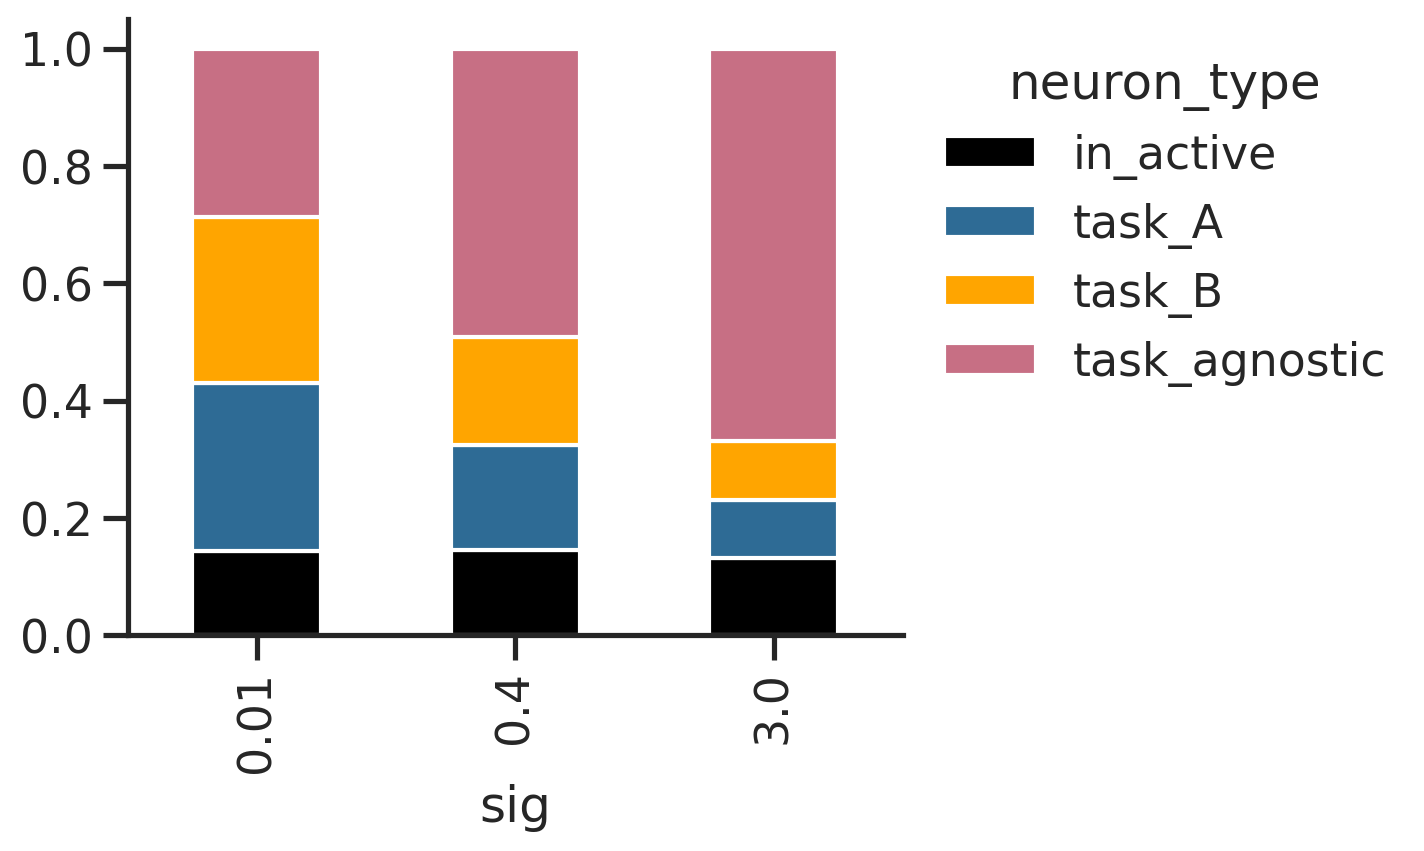

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
selectivity.pivot_table(values='percent',
                        index='sig',
                        columns='neuron_type',
                        aggfunc=np.mean).plot(
                            kind='bar', stacked=True, 
                            color=['k', viz.Blue, 'orange', viz.Red], ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<Axes: xlabel='corr', ylabel='Probability'>

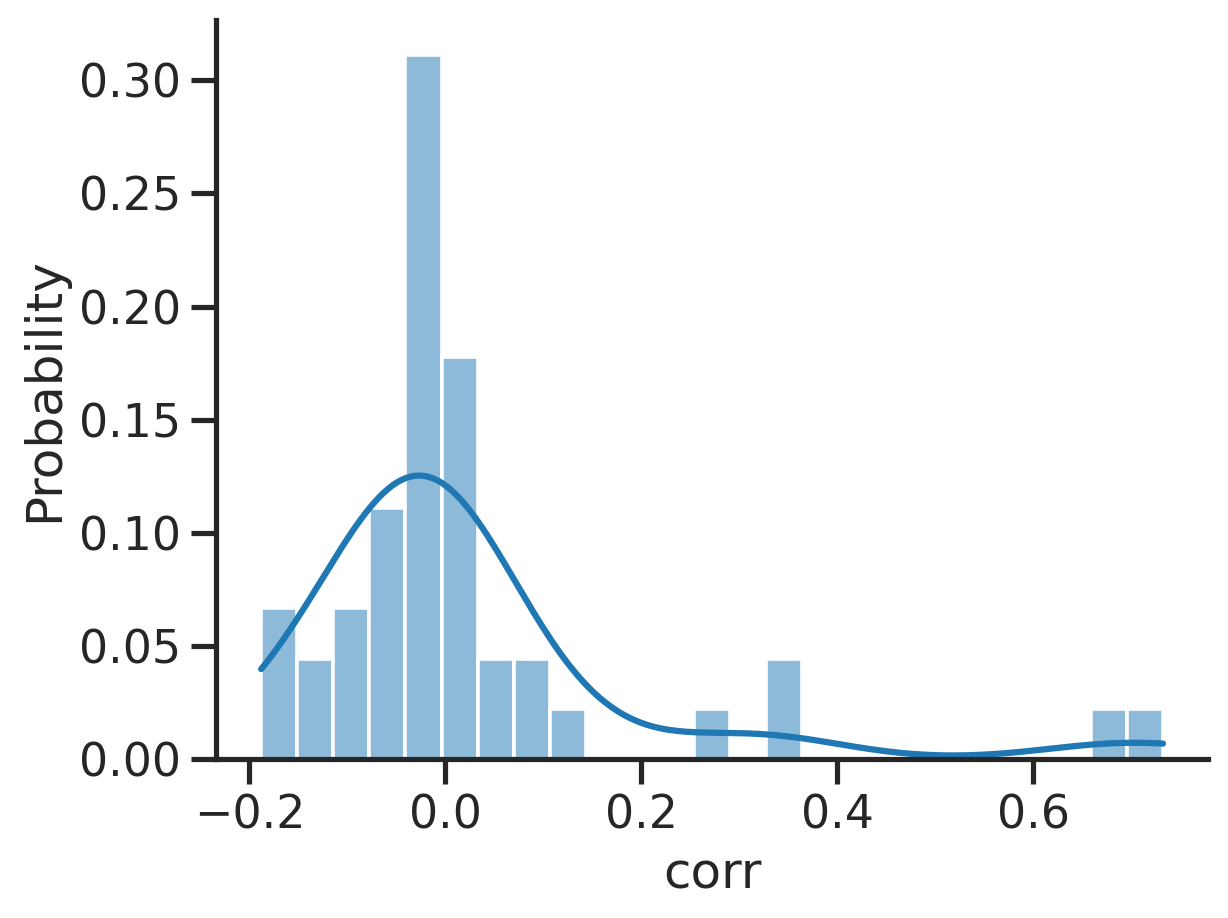

In [65]:
sns.histplot(selectivity.query(
    'neuron_type=="task_agnostic"')['corr'], 
    stat='probability', kde=True)

<Axes: xlabel='corr', ylabel='Probability'>

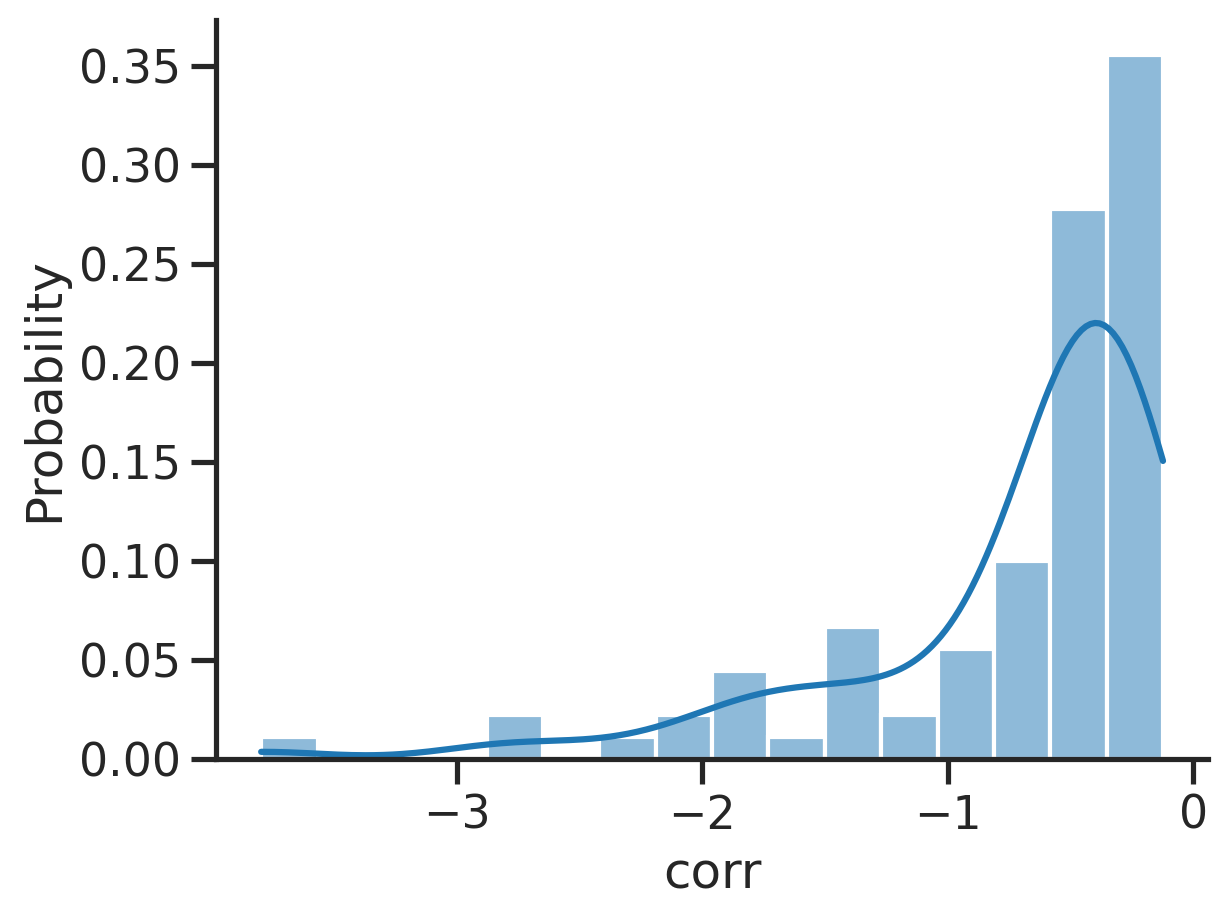

In [71]:
sns.histplot(selectivity.query(
    'neuron_type in ["task_A", "task_B"]')['corr'], 
    stat='probability', kde=True)


# Behavioral alignment

In [53]:
selectivity = {'v': [], 'task': [], 'neuron_type': [], 'sig': [], 'dim1':[], 'dim2':[]}
for sig_w in [.01, .4, 3]:
    sig_c = 1.5
    env  = gauss_blob_task()
    x, y = gauss_blob_task().instan()
    for i in range(len(weights[sig_w]['param'])):
        n = len(weights[sig_w]['param'])
        model = MLP(25, 2, 100, 1, .001, sig_w, sig_c, .1)
        model.w_hxs = weights[sig_w]['param'][i]['w1'][:, :25]
        model.w_hxc = weights[sig_w]['param'][i]['w1'][:, 25:]
        model.b_hx  = weights[sig_w]['param'][i]['b1']
        model.w_yh  = weights[sig_w]['param'][i]['w2']
        model.b_yh  = weights[sig_w]['param'][i]['b2']
        model.fprop(x[:, :25].T, x[:, 25:].T, y.reshape([1, -1]))
        z = model.h_out.T
        z_task_A = z[:25, :].mean(0)
        z_task_B = z[25:, :].mean(0)
        # agnostic 
        agno_cells = (z_task_A>0)*(z_task_B>0)
        task_agnostic = (agno_cells).sum() / 100
        agno_ind = np.where(agno_cells==1)[0].tolist()
        # task A
        task_A_specific = ((z_task_A>0)*(z_task_B==0)).sum() / 100
        task_A_cells = (z_task_A>0)*(z_task_B==0)
        task_A_ind = np.where(task_A_cells==1)[0].tolist()
        # task B
        task_B_specific = ((z_task_A==0)*(z_task_B>0)).sum() / 100
        task_B_cells = (z_task_A==0)*(z_task_B>0)
        task_B_ind = np.where(task_B_cells==1)[0].tolist()
        
        ## save 
        # task agnostic 
        v_agno_task_A = model.w_yh@((z[:25, :]*agno_cells.reshape([1, -1])).T) + model.b_yh
        v_agno_task_B = model.w_yh@((z[25:, :]*agno_cells.reshape([1, -1])).T) + model.b_yh
        # task specfic 
        v_spec_task_A = model.w_yh@((z[:25, :]*task_A_cells.reshape([1, -1])).T) + model.b_yh
        v_spec_task_B = model.w_yh@((z[25:, :]*task_B_cells.reshape([1, -1])).T) + model.b_yh

        ## save 
        selectivity['v'] += v_agno_task_A.reshape([-1]).tolist()\
                          + v_agno_task_B.reshape([-1]).tolist()\
                          + v_spec_task_A.reshape([-1]).tolist()\
                          + v_spec_task_B.reshape([-1]).tolist()
        selectivity['neuron_type'] += ['task_agno_A']*25\
                                     +['task_agno_B']*25\
                                     +['task_spec_A']*25\
                                     +['task_spec_B']*25
        selectivity['task'] += ['task A']*25+['task B']*25+['task A']*25+['task B']*25
        selectivity['sig'] += [sig_w]*25*4
        selectivity['dim1'] += np.tile([-2, -1, 0, 1, 2], 5).tolist()\
                             + np.tile([-2, -1, 0, 1, 2], 5).tolist()\
                             + np.tile([-2, -1, 0, 1, 2], 5).tolist()\
                             + np.tile([-2, -1, 0, 1, 2], 5).tolist()
        selectivity['dim2'] += np.repeat([-2, -1, 0, 1, 2], 5).tolist()\
                             + np.repeat([-2, -1, 0, 1, 2], 5).tolist()\
                             + np.repeat([-2, -1, 0, 1, 2], 5).tolist()\
                             + np.repeat([-2, -1, 0, 1, 2], 5).tolist()

In [54]:
neuron_typ = 'task_spec_A'
mat = pd.DataFrame(selectivity).query(
        f'neuron_type=="{neuron_typ}"').pivot_table(
            values='v',
            index='dim1',
            columns='dim2',
            aggfunc=np.mean
        ).values

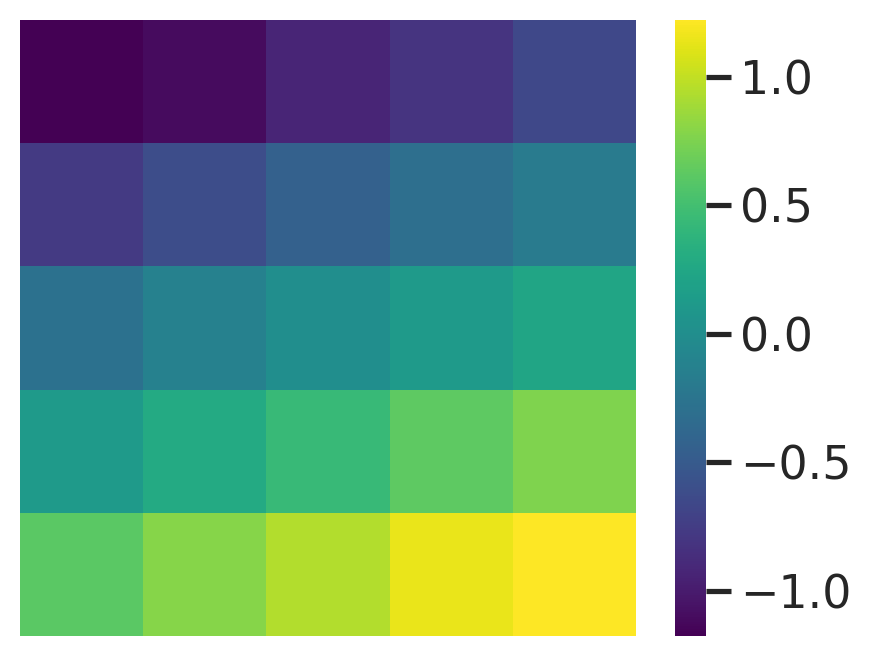

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(mat, cmap='viridis', ax=ax)
ax.set_box_aspect(1)
ax.set_axis_off()

In [14]:
v.reshape([-1, 5], order='F')

array([[-1.42247347, -1.54998397, -1.62508222, -1.60747079, -1.60819026],
       [-0.63076164, -0.70763128, -0.81212973, -0.89465621, -0.89885857],
       [ 0.1321591 ,  0.00652205, -0.18657875, -0.35851334, -0.37393998],
       [ 0.99096375,  0.9453476 ,  0.68855886,  0.3290899 ,  0.12509489],
       [ 1.97188739,  1.94043302,  1.57471346,  1.16065918,  0.89592226]])